In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed

import tensorflow as tf
from tensorflow.random import set_seed 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
#tf.logging.set_verbosity(tf.logging.ERROR)

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

seed(10)
set_seed(10)

In [3]:
train = pd.read_csv('/content/drive/MyDrive/02_코랩/02_ai팩토리/공기압축기_이상_판단/train_data.csv')
test = pd.read_csv('/content/drive/MyDrive/02_코랩/02_ai팩토리/공기압축기_이상_판단/test_data.csv')
answer_sample = pd.read_csv('/content/drive/MyDrive/02_코랩/02_ai팩토리/공기압축기_이상_판단/answer_sample.csv')

In [4]:
train.shape

(2463, 8)

In [5]:
test.shape

(7389, 8)

In [6]:
title_mapping = {0: 30, 4:30, 5:30, 6:30, 7:30, 1:20, 2:10, 3:50}
train['hp'] = train['type'].map(title_mapping)
test['hp'] = test['type'].map(title_mapping)

train['air_efficient'] = train['out_pressure']*train['air_inflow']
train['motor_load'] = train['motor_current']*train['motor_rpm']
train['new_var'] = (train['air_end_temp'] - train['motor_vibe']) / (train['air_end_temp'] + train['motor_vibe'])

test['air_efficient'] = test['out_pressure']*test['air_inflow']
test['motor_load'] = test['motor_current']*test['motor_rpm']
test['new_var'] = (test['air_end_temp'] - test['motor_vibe']) / (test['air_end_temp'] + test['motor_vibe'])

In [7]:
train

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,hp,air_efficient,motor_load,new_var
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0,30,1.113,34490.40,0.866606
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0,30,2.079,120652.80,0.881009
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0,30,1.337,50028.79,0.871101
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0,30,1.659,76758.78,0.876096
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0,30,1.330,49719.05,0.870888
...,...,...,...,...,...,...,...,...,...,...,...,...
2458,2.28,50.20,0.7,29.53,2416.0,66.84,3.34,7,30,1.596,71344.48,0.875233
2459,2.04,46.94,0.7,26.34,2155.0,63.94,3.20,7,30,1.428,56762.70,0.872357
2460,1.19,35.74,0.7,15.39,1259.0,53.99,2.70,7,30,0.833,19376.01,0.859521
2461,1.21,36.00,0.7,15.64,1280.0,54.22,2.71,7,30,0.847,20019.20,0.859985


In [8]:
train[train['type'] == 0].drop('type', axis = 1)

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,hp,air_efficient,motor_load,new_var
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,30,1.113,34490.40,0.866606
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,30,2.079,120652.80,0.881009
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,30,1.337,50028.79,0.871101
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,30,1.659,76758.78,0.876096
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,30,1.330,49719.05,0.870888
...,...,...,...,...,...,...,...,...,...,...,...
427,1.32,37.49,0.7,17.10,1399.0,55.54,2.78,30,0.924,23922.90,0.861932
428,1.80,43.85,0.7,23.32,1908.0,61.20,3.06,30,1.260,44494.56,0.869537
429,2.79,56.99,0.7,36.17,2959.0,72.88,3.64,30,1.953,107027.03,0.879927
430,2.25,49.79,0.7,29.13,2383.0,66.48,3.32,30,1.575,69416.79,0.874976


In [10]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train.drop('type', axis = 1))
X_test = scaler.transform(test.drop('type', axis = 1))

In [11]:
def type_index(data, index_data, type_number):
  data = data[index_data[index_data['type']==type_number].index]
  return data.reshape(data.shape[0], 1, data.shape[1])
type_index(X_train, train, 1)

array([[[0.237691  , 0.70239903, 0.        , ..., 0.237691  ,
         0.2791118 , 0.9723059 ]],

       [[0.1663837 , 0.42575159, 0.        , ..., 0.1663837 ,
         0.1479278 , 0.96143578]],

       [[0.16977929, 0.44215002, 0.        , ..., 0.16977929,
         0.15464405, 0.96243028]],

       ...,

       [[0.08488964, 0.11691467, 0.        , ..., 0.08488964,
         0.04479486, 0.94404379]],

       [[0.24448217, 0.72335257, 0.        , ..., 0.24448217,
         0.29045072, 0.97300296]],

       [[0.08828523, 0.12450653, 0.        , ..., 0.08828523,
         0.04682622, 0.94388668]]])

In [12]:
# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# print(X_train.shape)
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
# print(X_test.shape)

In [13]:
def autoencoder_model(X):
  inputs = Input(shape =(X.shape[1], X.shape[2]))
  L1 = LSTM(140, activation='gelu', return_sequences=True,
            kernel_regularizer=regularizers.l2(0.00))(inputs)
  L2 = LSTM(70, activation='gelu', return_sequences=False)(L1)
  L3 = RepeatVector(X.shape[1])(L2)
  L4 = LSTM(70, activation='gelu', return_sequences=True)(L3)
  L5 = LSTM(140, activation='gelu', return_sequences=True)(L4)
  output = TimeDistributed(Dense(X.shape[2]))(L5)
  model = Model(inputs = inputs, outputs = output)
  return model

In [14]:
from tensorflow.keras.optimizers import AdamW
optimizer = AdamW(learning_rate=0.001, weight_decay=0.01)

X_train0 = type_index(X_train, train, 0)
X_train1 = type_index(X_train, train, 1)
X_train2 = type_index(X_train, train, 2)
X_train3 = type_index(X_train, train, 3)
X_train4 = type_index(X_train, train, 4)
X_train5 = type_index(X_train, train, 5)
X_train6 = type_index(X_train, train, 6)
X_train7 = type_index(X_train, train, 7)


model_type0 = autoencoder_model(X_train0)
model_type1 = autoencoder_model(X_train1)
model_type2 = autoencoder_model(X_train2)
model_type3 = autoencoder_model(X_train3)
model_type4 = autoencoder_model(X_train4)
model_type5 = autoencoder_model(X_train5)
model_type6 = autoencoder_model(X_train6)
model_type7 = autoencoder_model(X_train7)

model_type2.compile(optimizer =optimizer, loss='mae')
model_type3.compile(optimizer =optimizer, loss='mae')
model_type4.compile(optimizer =optimizer, loss='mae')
model_type5.compile(optimizer =optimizer, loss='mae')
model_type6.compile(optimizer =optimizer, loss='mae')
model_type7.compile(optimizer =optimizer, loss='mae')

In [16]:
nb_epochs = 200
batch_size = 20

model_type0.compile(optimizer =AdamW(learning_rate=0.001, weight_decay=0.01), loss='mae')
history0 = model_type0.fit(X_train0, X_train0, epochs = nb_epochs, batch_size = batch_size, validation_split = 0.05).history

model_type1.compile(optimizer =AdamW(learning_rate=0.001, weight_decay=0.01), loss='mae')
history1 = model_type1.fit(X_train1, X_train1, epochs = nb_epochs, batch_size = batch_size, validation_split = 0.05).history

model_type2.compile(optimizer =AdamW(learning_rate=0.001, weight_decay=0.01), loss='mae')
history2 = model_type2.fit(X_train2, X_train2, epochs = nb_epochs, batch_size = batch_size, validation_split = 0.05).history

model_type3.compile(optimizer =AdamW(learning_rate=0.001, weight_decay=0.01), loss='mae')
history3 = model_type3.fit(X_train3, X_train3, epochs = nb_epochs, batch_size = batch_size, validation_split = 0.05).history

model_type4.compile(optimizer =AdamW(learning_rate=0.001, weight_decay=0.01), loss='mae')
history4 = model_type4.fit(X_train4, X_train4, epochs = nb_epochs, batch_size = batch_size, validation_split = 0.05).history

model_type5.compile(optimizer =AdamW(learning_rate=0.001, weight_decay=0.01), loss='mae')
history5 = model_type5.fit(X_train5, X_train5, epochs = nb_epochs, batch_size = batch_size, validation_split = 0.05).history

model_type6.compile(optimizer =AdamW(learning_rate=0.001, weight_decay=0.01), loss='mae')
history6 = model_type6.fit(X_train6, X_train6, epochs = nb_epochs, batch_size = batch_size, validation_split = 0.05).history

model_type7.compile(optimizer =AdamW(learning_rate=0.001, weight_decay=0.01), loss='mae')
history7 = model_type7.fit(X_train7, X_train7, epochs = nb_epochs, batch_size = batch_size, validation_split = 0.05).history

Epoch 1/200
21/21 [==============================] - 11s 52ms/step - loss: 0.0628 - val_loss: 0.0567
Epoch 2/200
21/21 [==============================] - 0s 14ms/step - loss: 0.0580 - val_loss: 0.0533
Epoch 3/200
21/21 [==============================] - 0s 14ms/step - loss: 0.0539 - val_loss: 0.0494
Epoch 4/200
21/21 [==============================] - 0s 14ms/step - loss: 0.0498 - val_loss: 0.0458
Epoch 5/200
21/21 [==============================] - 0s 13ms/step - loss: 0.0444 - val_loss: 0.0406
Epoch 6/200
21/21 [==============================] - 0s 14ms/step - loss: 0.0399 - val_loss: 0.0349
Epoch 7/200
21/21 [==============================] - 0s 13ms/step - loss: 0.0332 - val_loss: 0.0283
Epoch 8/200
21/21 [==============================] - 0s 14ms/step - loss: 0.0269 - val_loss: 0.0231
Epoch 9/200
21/21 [==============================] - 0s 13ms/step - loss: 0.0230 - val_loss: 0.0189
Epoch 10/200
21/21 [==============================] - 0s 16ms/step - loss: 0.0182 - val_loss: 0.016

In [19]:
def loss_visual(history):
  fig, ax = plt.subplots(figsize = (14, 6), dpi = 80)
  ax.plot(history["loss"], "b", label = "Train", linewidth = 2)
  ax.plot(history["val_loss"], "r", label = "Validation", linewidth = 2)
  ax.set_ylabel("Loss (mae")
  ax.set_xlabel("Epoch")
  ax.legend(loc="upper right")

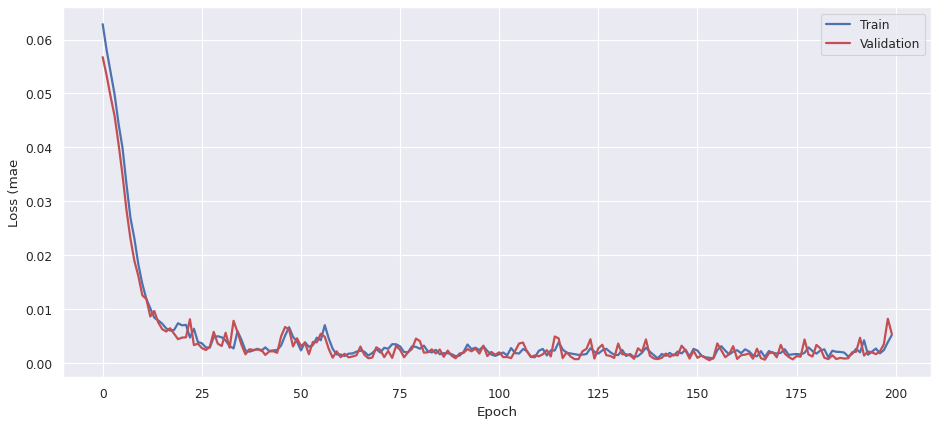

In [21]:
loss_visual(history0)

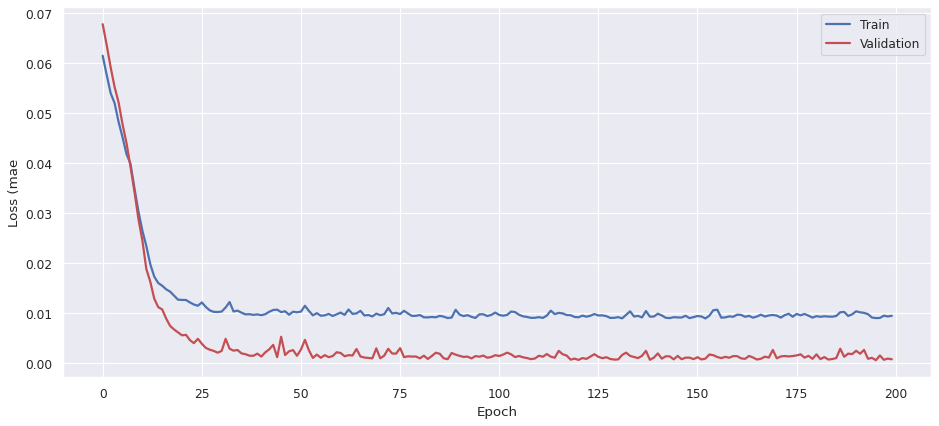

In [22]:
loss_visual(history1)

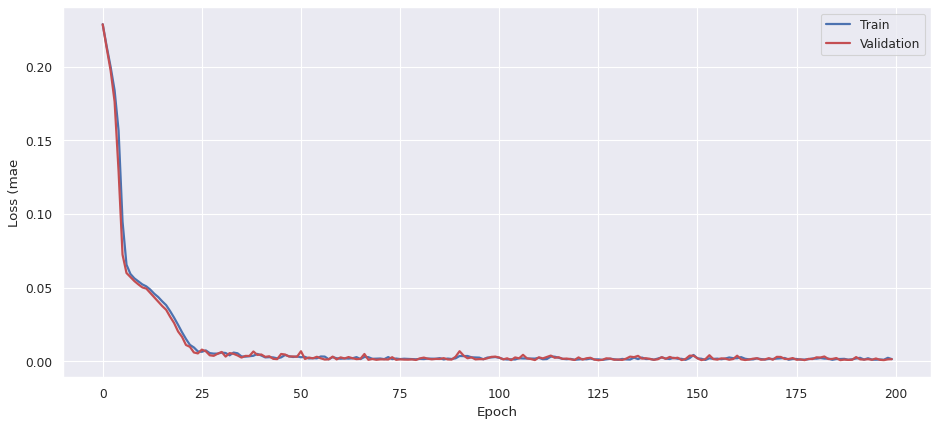

In [23]:
loss_visual(history2)

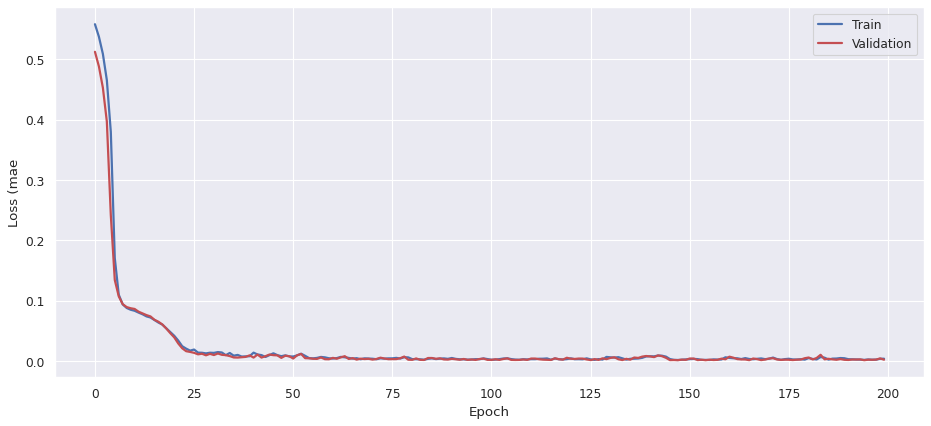

In [24]:
loss_visual(history3)

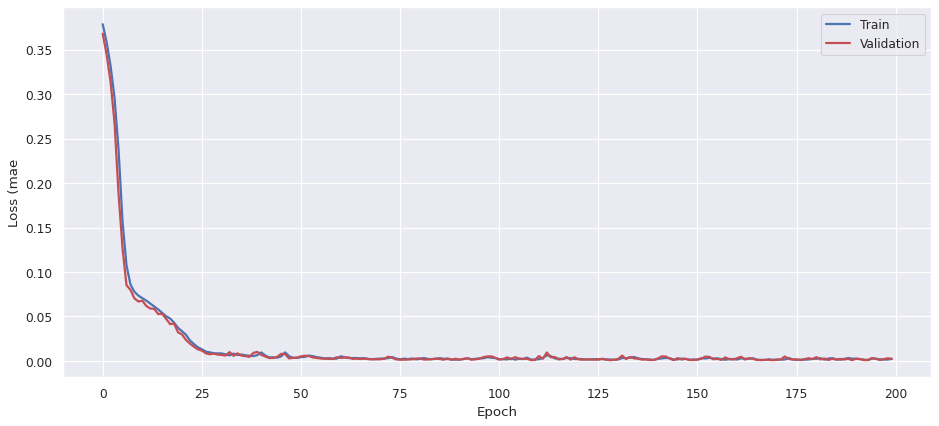

In [25]:
loss_visual(history4)

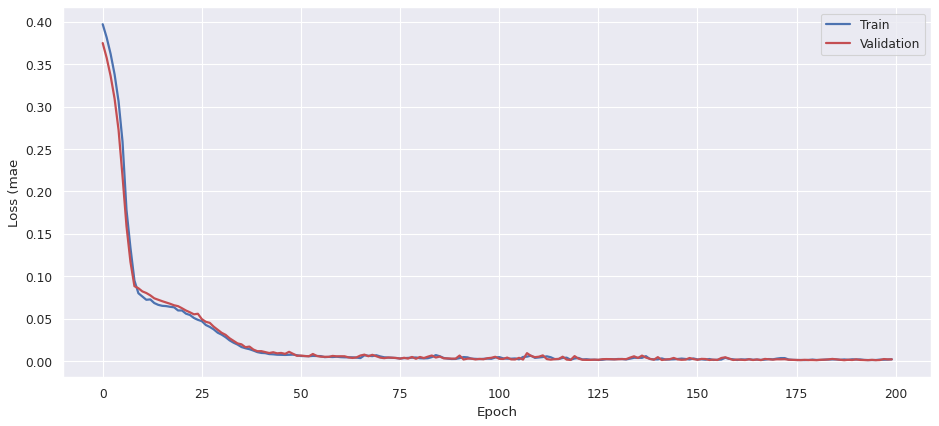

In [26]:
loss_visual(history5)

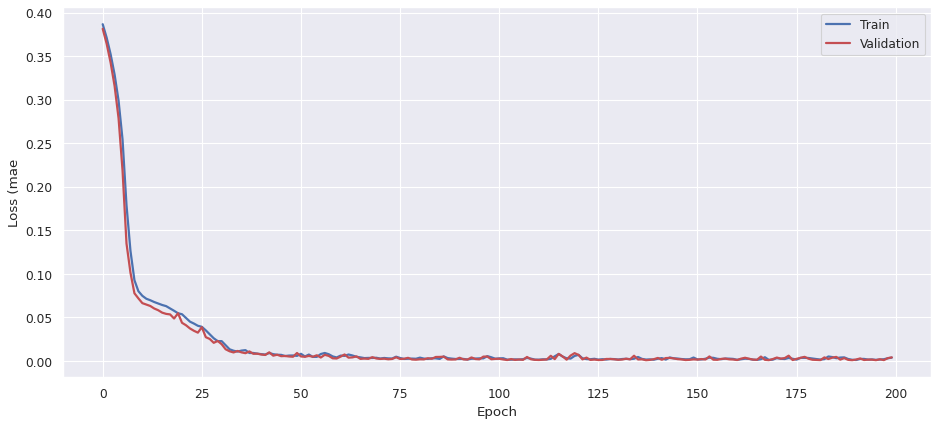

In [27]:
loss_visual(history6)

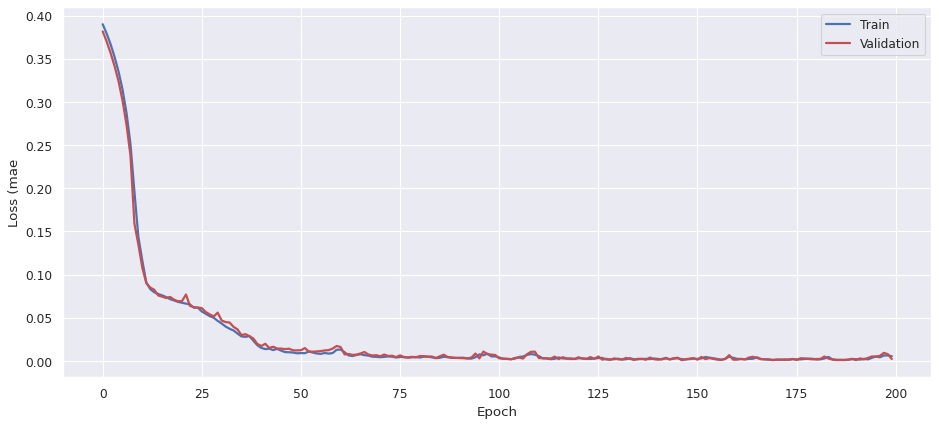

In [28]:
loss_visual(history7)

In [31]:
model_type1.compile(optimizer =AdamW(learning_rate=0.001, weight_decay=0.01), loss='mae')
history1 = model_type1.fit(X_train1, X_train1, epochs = 10, batch_size = batch_size, validation_split = 0.05).history

Epoch 1/10
18/18 [==============================] - 13s 66ms/step - loss: 0.0139 - val_loss: 0.0023
Epoch 2/10
18/18 [==============================] - 0s 18ms/step - loss: 0.0099 - val_loss: 9.3084e-04
Epoch 3/10
18/18 [==============================] - 0s 18ms/step - loss: 0.0092 - val_loss: 9.4218e-04
Epoch 4/10
18/18 [==============================] - 0s 19ms/step - loss: 0.0090 - val_loss: 0.0011
Epoch 5/10
18/18 [==============================] - 0s 17ms/step - loss: 0.0092 - val_loss: 0.0012
Epoch 6/10
18/18 [==============================] - 0s 18ms/step - loss: 0.0092 - val_loss: 0.0014
Epoch 7/10
18/18 [==============================] - 0s 17ms/step - loss: 0.0102 - val_loss: 0.0013
Epoch 8/10
18/18 [==============================] - 0s 18ms/step - loss: 0.0094 - val_loss: 8.9448e-04
Epoch 9/10
18/18 [==============================] - 0s 26ms/step - loss: 0.0097 - val_loss: 0.0011
Epoch 10/10
18/18 [==============================] - 0s 24ms/step - loss: 0.0096 - val_loss: 6.3

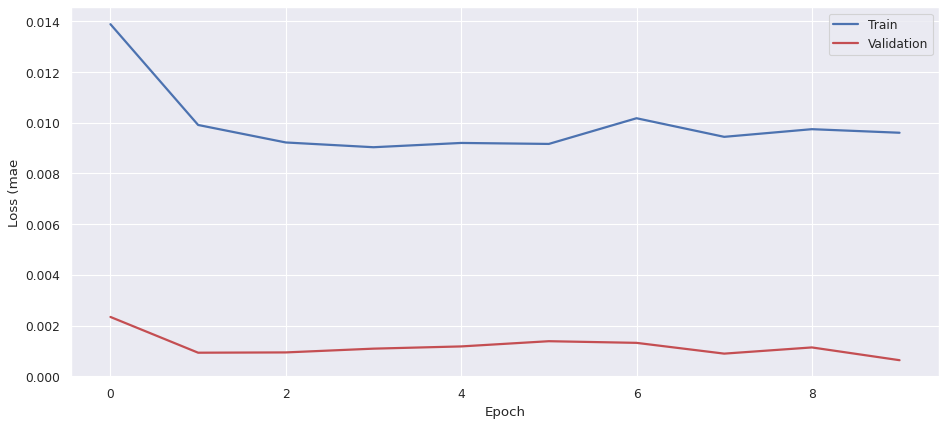

In [32]:
loss_visual(history1)

In [36]:
train.shape

(2463, 12)

In [38]:
def predict_by_type(model, train_data, test_data, type_number):
  X_pred = model.predict(train_data)
  X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
  X_pred = pd.DataFrame(X_pred, columns = train.drop('type', axis = 1).columns)
  X_pred.index = train[train['type']==type_number].index

  scored = pd.DataFrame(index=train[train['type']==type_number].index)
  train_data = train_data.reshape(train_data.shape[0], train_data.shape[2])
  scored["Loss_mae"] = np.mean(np.abs(X_pred-train_data), axis = 1)
  plt.figure(figsize=(16,9), dpi = 80)
  sns.distplot(scored["Loss_mae"], bins = 20, kde = True, color = "blue");
  plt.xlim([0.0,0.1])

  print("anomaly threshold = {}".format(np.percentile(scored, 100)))
  threshold = np.percentile(scored, 99)

  X_pred = model.predict(test_data)
  X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
  X_pred = pd.DataFrame(X_pred, columns=test.drop('type', axis = 1).columns)
  X_pred.index = test[test['type']==type_number].index

  scored = pd.DataFrame(index = test[test['type']==type_number].index)
  test_data = test_data.reshape(test_data.shape[0], test_data.shape[2])
  scored["Loss_mae"] = np.mean(np.abs(X_pred-test_data), axis = 1)
  scored["Threshold"] = threshold
  scored["Anomaly"] = scored["Loss_mae"] > scored["Threshold"]
  scored.head()
  return scored

14/14 [==============================] - 0s 4ms/step
anomaly threshold = 0.016683028488178556


<ipython-input-38-1d4fe681af1e>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored["Loss_mae"], bins = 20, kde = True, color = "blue");


41/41 [==============================] - 0s 4ms/step


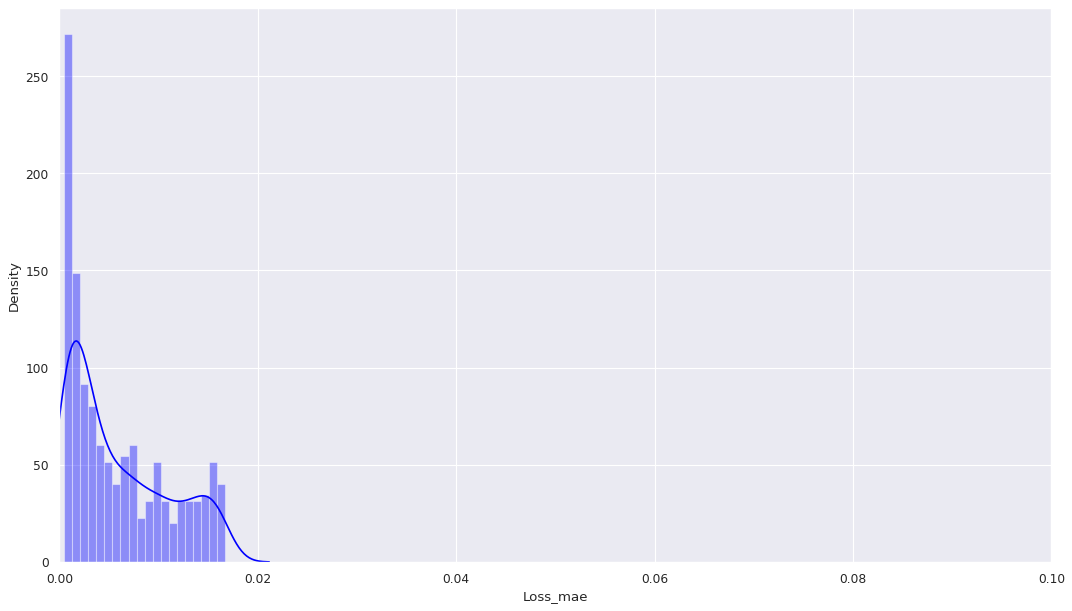

In [48]:
nunber = 0
scored0 = predict_by_type(model_type0, type_index(X_train, train, nunber), type_index(X_test, test, nunber), nunber)

In [49]:
scored0

,Loss_mae,Threshold,Anomaly
0,0.005895,0.016486,False
1,0.007342,0.016486,False
2,0.000822,0.016486,False
3,0.003494,0.016486,False
4,0.002605,0.016486,False
...,...,...,...
1291,0.001424,0.016486,False
1292,0.013741,0.016486,False
1293,0.001728,0.016486,False
1294,0.002030,0.016486,False


12/12 [==============================] - 0s 7ms/step


<ipython-input-38-1d4fe681af1e>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored["Loss_mae"], bins = 20, kde = True, color = "blue");


anomaly threshold = 0.24667641189616785
35/35 [==============================] - 0s 9ms/step


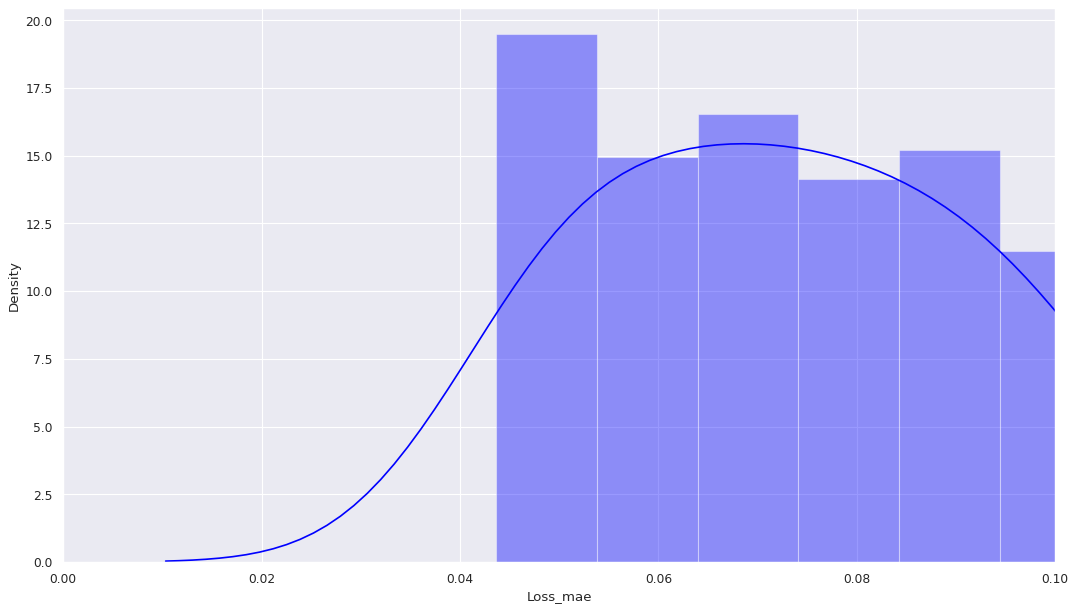

In [50]:
nunber = 1
scored1 = predict_by_type(model_type0, type_index(X_train, train, nunber), type_index(X_test, test, nunber), nunber)

12/12 [==============================] - 0s 4ms/step
anomaly threshold = 0.21351801733354944


<ipython-input-38-1d4fe681af1e>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored["Loss_mae"], bins = 20, kde = True, color = "blue");


35/35 [==============================] - 0s 7ms/step


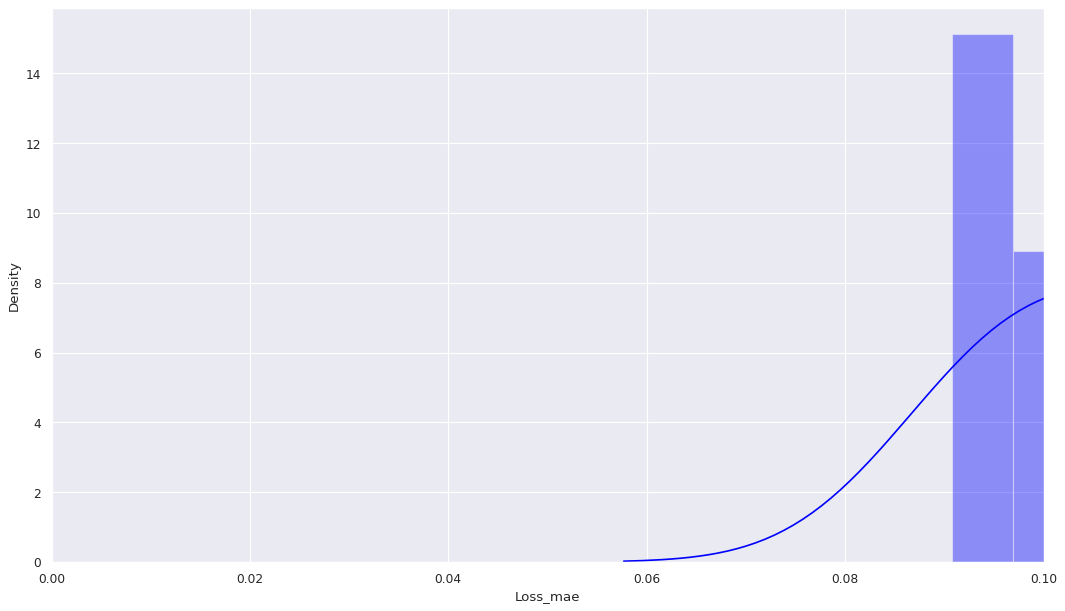

In [51]:
nunber = 2
scored2 = predict_by_type(model_type0, type_index(X_train, train, nunber), type_index(X_test, test, nunber), nunber)

10/10 [==============================] - 0s 9ms/step


<ipython-input-38-1d4fe681af1e>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored["Loss_mae"], bins = 20, kde = True, color = "blue");


anomaly threshold = 0.28173773254380213
29/29 [==============================] - 0s 7ms/step


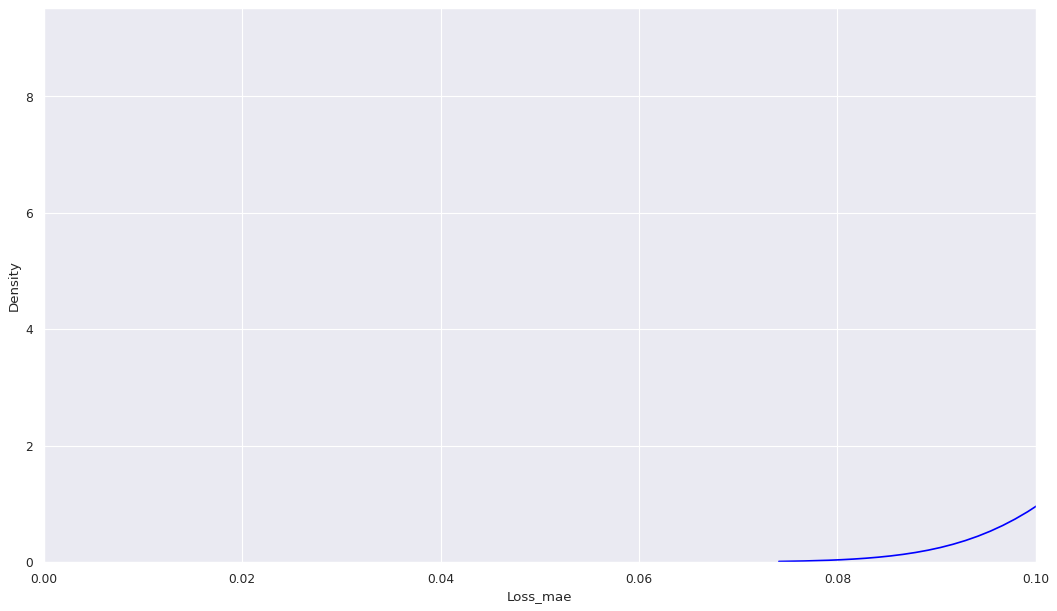

In [52]:
nunber = 3
scored3 = predict_by_type(model_type0, type_index(X_train, train, nunber), type_index(X_test, test, nunber), nunber)

10/10 [==============================] - 0s 7ms/step


<ipython-input-38-1d4fe681af1e>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored["Loss_mae"], bins = 20, kde = True, color = "blue");


anomaly threshold = 0.016692846333130243
29/29 [==============================] - 0s 8ms/step


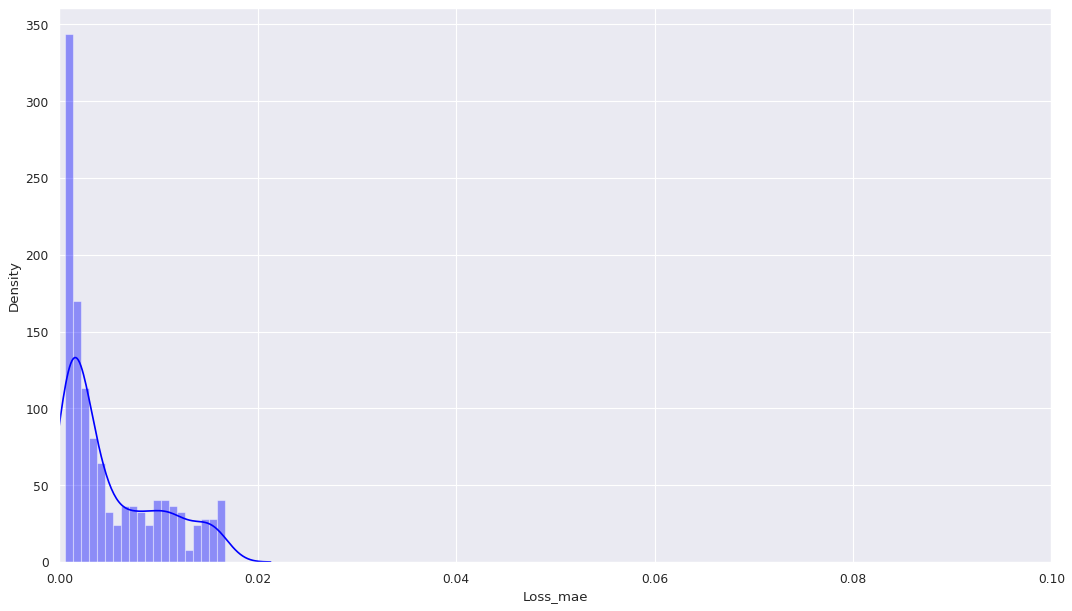

In [53]:
nunber = 4
scored4 = predict_by_type(model_type0, type_index(X_train, train, nunber), type_index(X_test, test, nunber), nunber)

8/8 [==============================] - 0s 12ms/step


<ipython-input-38-1d4fe681af1e>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored["Loss_mae"], bins = 20, kde = True, color = "blue");


anomaly threshold = 0.01659192652162409
24/24 [==============================] - 0s 5ms/step


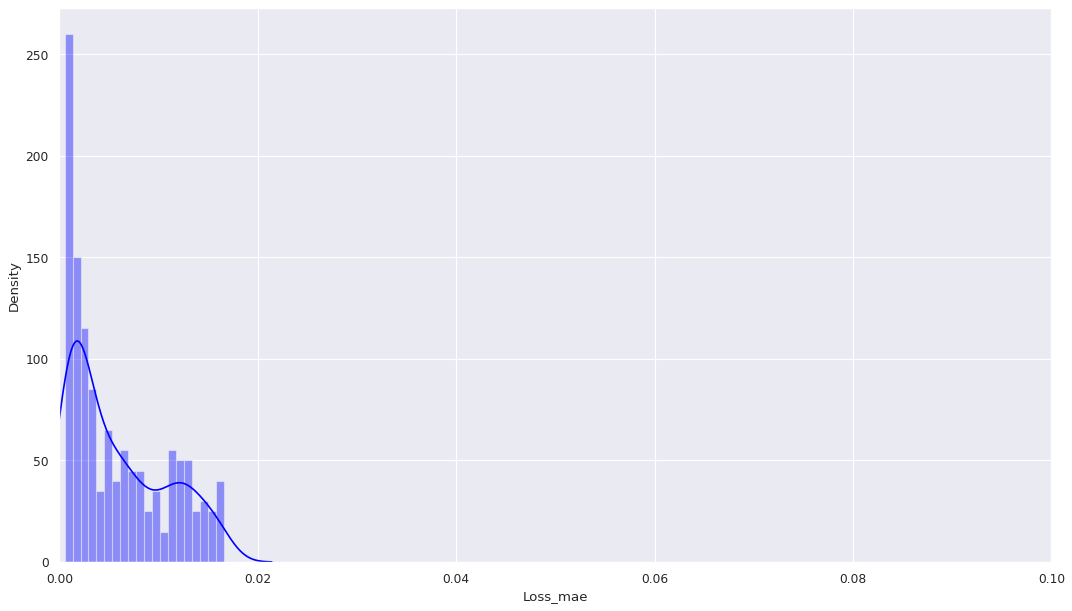

In [54]:
nunber = 5
scored5 = predict_by_type(model_type0, type_index(X_train, train, nunber), type_index(X_test, test, nunber), nunber)

8/8 [==============================] - 0s 8ms/step


<ipython-input-38-1d4fe681af1e>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored["Loss_mae"], bins = 20, kde = True, color = "blue");


anomaly threshold = 0.01659192652162409
24/24 [==============================] - 0s 8ms/step


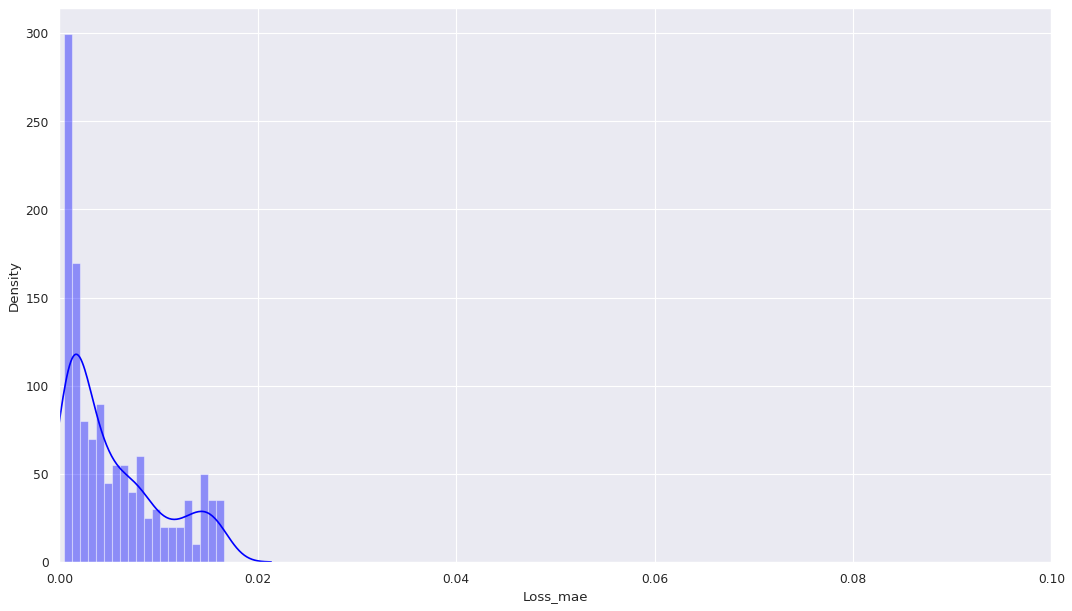

In [55]:
nunber = 6
scored6 = predict_by_type(model_type0, type_index(X_train, train, nunber), type_index(X_test, test, nunber), nunber)

6/6 [==============================] - 0s 7ms/step


<ipython-input-38-1d4fe681af1e>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored["Loss_mae"], bins = 20, kde = True, color = "blue");


anomaly threshold = 0.016475691039016693
18/18 [==============================] - 0s 7ms/step


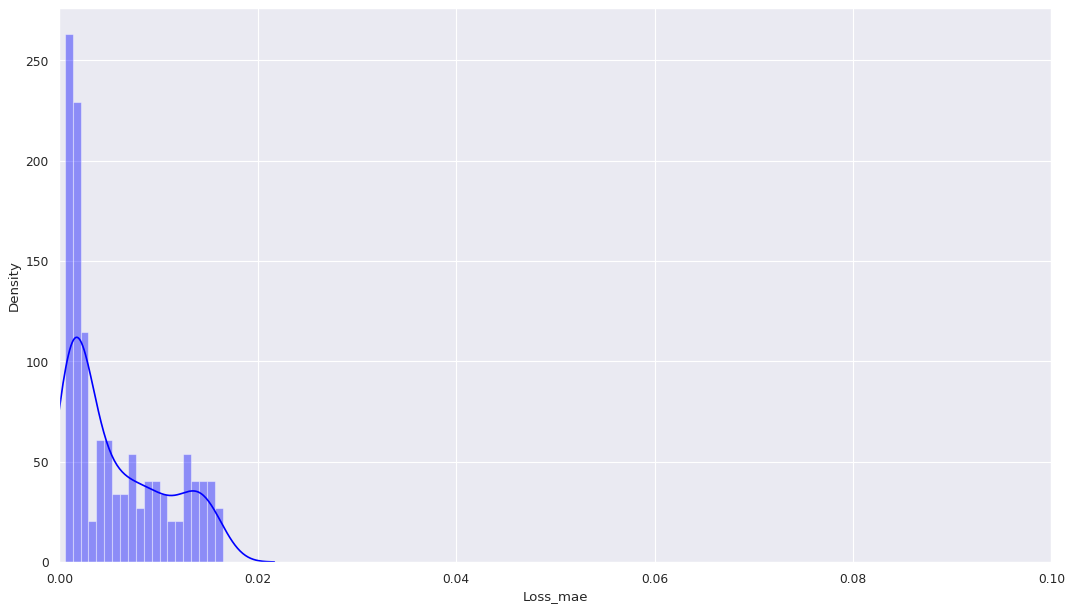

In [56]:
nunber = 7
scored7 = predict_by_type(model_type0, type_index(X_train, train, nunber), type_index(X_test, test, nunber), nunber)

In [58]:
scored = pd.concat([scored0, scored1, scored2, scored3, scored4, scored5, scored6, scored7])

In [59]:
scored["Anomaly"].value_counts()

False    7132
True      257
Name: Anomaly, dtype: int64

In [60]:
answer_sample["label"] = scored["Anomaly"]
answer_sample.head()
answer_sample["label"].value_counts()

False    7132
True      257
Name: label, dtype: int64

In [61]:
answer_sample.to_csv("/content/drive/MyDrive/02_코랩/02_ai팩토리/공기압축기_이상_판단/submission0414.csv", index=False)

In [ ]:
model.save('/content/drive/MyDrive/02_코랩/02_ai팩토리/공기압축기_이상_판단/model.h5')